In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
import warnings

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
class featureDB(db.Database):
    def __init__(self, database, driver='sqlite', host=None, port=None, dbTables=None, *args, **kwargs):
        """
        Instantiate object to handle queries of the opsim database.
        (In general these will be the sqlite database files produced by opsim, but could
        be any database holding those opsim output tables.).

        database = Name of database or sqlite filename
        driver =  Name of database dialect+driver for sqlalchemy (e.g. 'sqlite', 'pymssql+mssql')
        host = Name of database host (optional)
        port = String port number (optional)

        """
        # Default dbTables and dbTableIDKey values:
        if 'defaultdbTables' in kwargs:
            defaultdbTables = kwargs.get('defaultdbTables')
            # Remove this kwarg since we're sending it on explicitly
            del kwargs['defaultdbTables']
        else:
            defaultdbTables = {'Summary': ['Summary', 'obsHistID']
                               }
        # Call base init method to set up all tables and place default values
        # into dbTable/dbTablesIdKey if not overriden.
        super(featureDB, self).__init__(driver=driver, database=database, host=host, port=port,
                                            dbTables=dbTables,
                                            defaultdbTables=defaultdbTables,
                                            *args, **kwargs)
        # Save filterlist so that we get the filter info per proposal in this desired order.
        self.filterlist = np.array(['u', 'g', 'r', 'i', 'z', 'y'])
        # Set internal variables for column names.
        self._colNames()

    def _colNames(self):
        """
        Set variables to represent the common column names used in this class directly.

        This should make future schema changes a little easier to handle.
        It is NOT meant to function as a general column map, just to abstract values
        which are used *within this class*.
        """
        self.mjdCol = 'expMJD'
        self.fieldIdCol = 'fieldID'
        self.raCol = 'fieldRA'
        self.decCol = 'fieldDec'
        #self.propIdCol = 'propID'
        #self.propConfCol = 'propConf'
        #self.propNameCol = 'propName' #(propname == proptype)
        # For config parsing.
        #self.versionCol = 'version'
        #self.sessionDateCol = 'sessionDate'
        #self.runCommentCol = 'runComment'

    def fetchMetricData(self, colnames, sqlconstraint, distinctExpMJD=True, groupBy='expMJD',
                        tableName='Summary'):
        """
        Fetch 'colnames' from 'tableName'.

        colnames = the columns to fetch from the table.
        sqlconstraint = sql constraint to apply to data (minus "WHERE").
        distinctExpMJD = group by expMJD to get unique observations only (default True).
        groupBy = group by col 'groupBy' (will override group by expMJD).
        tableName = the opsim table to query.
        """
        # To fetch data for a particular proposal only, add 'propID=[proposalID number]' as constraint,
        #  and to fetch data for a particular filter only, add 'filter ="[filtername]"' as a constraint.
        if (groupBy is None) and (distinctExpMJD is False):
            warnings.warn('Doing no groupBy, data could contain repeat visits that satisfy multiple proposals')

        table = self.tables[tableName]
        if (groupBy is not None) and (groupBy != self.mjdCol):
            if distinctExpMJD:
                warnings.warn('Cannot group by more than one column. Using explicit groupBy col %s' % (groupBy))
            metricdata = table.query_columns_Array(chunk_size=self.chunksize,
                                                   constraint=sqlconstraint,
                                                   colnames=colnames, groupByCol=groupBy)
        elif distinctExpMJD:
            metricdata = table.query_columns_Array(chunk_size=self.chunksize,
                                                   constraint=sqlconstraint,
                                                   colnames=colnames,
                                                   groupByCol=self.mjdCol)
        else:
            metricdata = table.query_columns_Array(chunk_size=self.chunksize,
                                                   constraint=sqlconstraint,
                                                   colnames=colnames)
        return metricdata


In [3]:
# make a stacker to tack on the columns that are standard
class opsim_col_stacker(stackers.BaseStacker):
    def __init__(self):
        self.colsAdded = ['poop'] #['fieldRA', 'fieldDec']
        self.units = ['radians', 'radians']
        self.colsReq = ['expMJD']
        #self.fieldData = np.loadtxt('fieldID.dat', delimiter='|', skiprows=1,
        #                dtype=zip(['id', 'ra', 'dec'], [int, float, float]))
    def _run(self, simData):
        #simData = np.sort(simData, order='fieldID')
        #indexes = np.searchsorted(self.fieldData['id'], simData['Field_id'])
        
        #simData['fieldRA'] = np.radians(self.fieldData['ra'][indexes])
        #simData['fieldDec'] = np.radians(self.fieldData['dec'][indexes])
        
        simData = np.sort(simData, order='expMJD')
        return simData

In [4]:
# Connect to the database
#edb = featureDB('/Users/yoachim/Scratch/Opsim_sqlites/Elahe/QuadDB.db')
edb = db.OpsimDatabase('/Users/yoachim/Scratch/Opsim_sqlites/Elahe/MafFBDE.db')

In [5]:
# ack = edb.fetchMetricData(['Field_id'], 'ephemDate < 1e6')
ack = edb.fetchMetricData(['fieldRA', 'fieldDec'], '')

In [6]:
ack['fieldRA']

array([ 4.65814678,  4.71317088,  4.76892842, ...,  0.93225465,
        0.90644576,  0.88052441])

In [7]:
bundleList = []

metric = metrics.CountMetric('expMJD')
slicer=slicers.HealpixSlicer()

# hack the slicer a bit

# slicer.columnsNeeded = ['Field_id']
# slicer.needsFields = False

sql=''
stacker = opsim_col_stacker()

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [8]:
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql))# , stackerList=[])

metric = metrics.MeanMetric(col='airmass')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql))


In [11]:
slicer = slicers.HealpixSlicer(nside=64, latCol='zenithDistance', lonCol='azimuth', useCache=False)
metric = metrics.CountMetric('expMJD', metricName='NVisits Alt/Az')
plotFuncs = [plots.LambertSkyMap()]
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, 
                                            plotFuncs=plotFuncs))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [12]:
bdict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bdict, edb, outDir='temp')
bgroup.runAll()

Querying database with no constraint.
Found 28931 visits
Running:  ['opsim_Count_expMJD_HEAL', 'opsim_Mean_airmass_HEAL']
Completed metric generation.
Running:  ['opsim_NVisits_Alt_Az_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with  constraint now.
monopole: -2.77993  dipole: lon: -9.12512, lat: -39.6739, amp: 37.0604
monopole: 1.25973  dipole: lon: 176.812, lat: 49.5976, amp: 0.181358
Plotting complete.


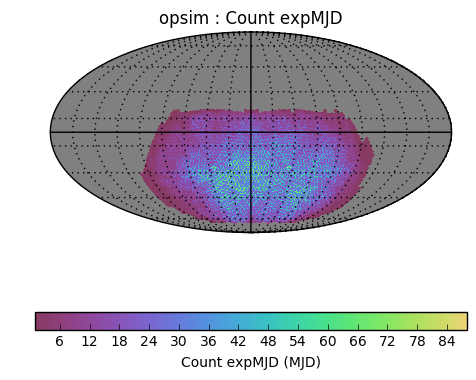

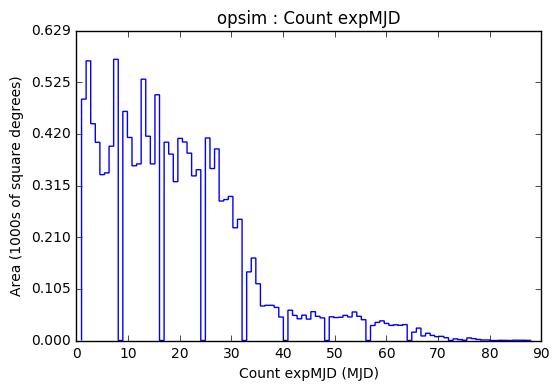

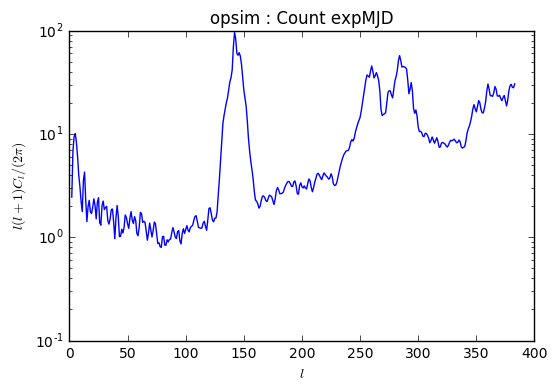

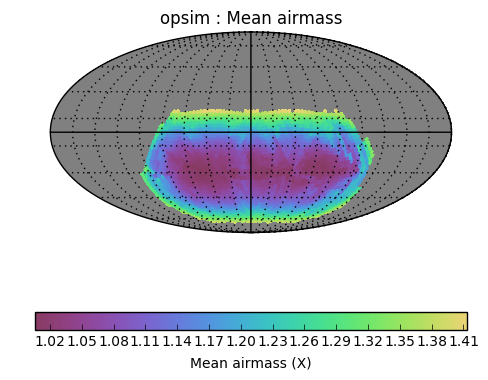

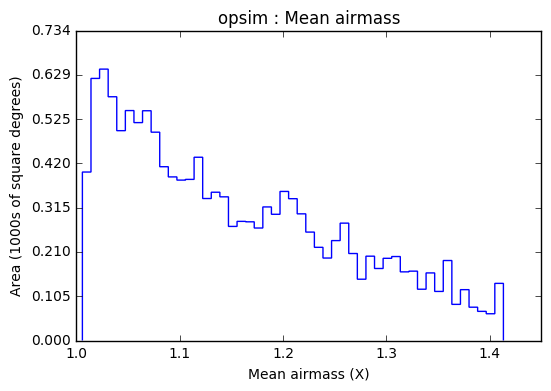

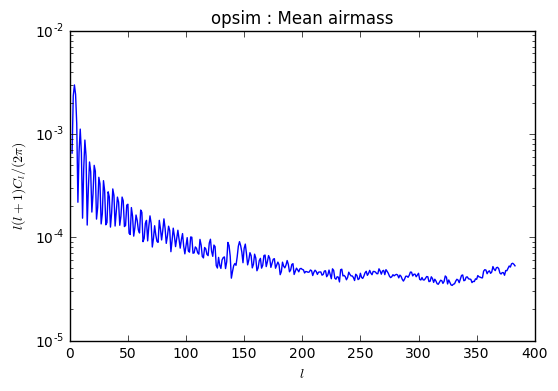

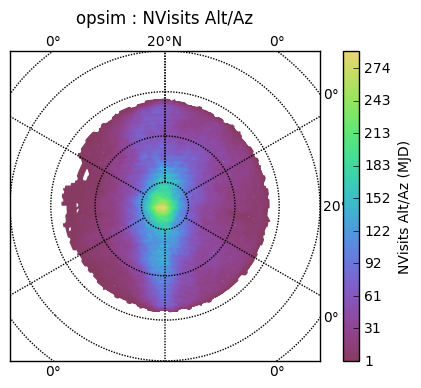

In [13]:
bgroup.plotAll(closefigs=False)

In [ ]:
ack = np.array([0,0,0,1,2,3,3,3])
blah = np.array([0,1,2,3])

In [ ]:
np.searchsorted(ack,blah)